# Predicting Fake News From Real (But Similar) News

Using natural language processing and classification, the aim of this project is to predict whether a given headline is from a legitimate news source or if it was produce by the satire team at theonion.com.

In [1]:
# ACQUIRE
import numpy as np
import pandas as pd
from acquire import acquire_headlines

# PREPARE
from prepare import get_prepped_data
from sklearn.model_selection import train_test_split

# VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# EXPLORE
from explore import h_bar_proportions
from explore import idf
from scipy import stats
import nltk

# MODELING
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# EVALUATION
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Acquire

Acquiring the data is accomplished through interaction with Reddit's API. Documentation about the API used for this project can be found at: https://github.com/pushshift/api

The r/TheOnion subreddit was created on March 23, 2008, but the first post didn't occur until October 28, 2008. The r/NotTheOnion subreddit was created on October 25, 2008. Our data consists of the top 100 posts (by score) for every day starting on Oct 1, 2008 through December 3, 2020. 

Our requests to Reddit's API returned json pages that have been collated and stored in 'onion.json' for r/TheOnion and 'not_onion.json' for r/NotTheOnion. Our acquire_headlines function retrieves the 'title' information from our json files and puts them into a dataframe with a label column distinguishing headlines from r/TheOnion (1) and r/NotTheOnion (0). 

In [2]:
df = acquire_headlines()
df

,label,headline
0,1,Biden Loses Control Of Butterfly Knife During ...
1,1,'Middle-Aged Woman Angrily Demanding Price Che...
2,1,Pope Summons World’s Bishops For Meeting On Se...
3,1,"ATTENTION, SHOWTIME: ClickHole Will Now Auditi..."
4,1,House Chaplain Delivers Soulful Prayer For God...
...,...,...
260302,0,"In Japan, it's the new fad of showing affectio..."
260303,0,Cops to get their own social network
260304,0,Need a companion? You can now 'Rent-a-Friend'
260305,0,Hardware store tools used in surgeries


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260307 entries, 0 to 260306
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   label     260307 non-null  int64 
 1   headline  260307 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.0+ MB


# Prepare

Utilizing the `get_prepped_data()` function from our prepare.py file, we modify the dataframe by:
1. Cleaning the raw strings in the readme_contents column by eliminating non-alphanumeric characters and single character words from the raw strings.  
1. Tokenizing the words using TokTokTokenizer.  
1. Adding a stemmed column made from the use of PorterStemmer() from the nltk library.  
1. Adding a lemmatized column made from the use of WordNetLemmatizer from the nltk library.  
1. Removing stopwords from the lemmatized results to create the clean column.  
1. Adding the stopwords_removed column. This provides a count of the number of stopwords removed from the lemmatized string.  
1. Adding the doc_length column. This provides the total number of words in the contents of the clean column.  
1. Adding the words column. This contains a list of the words found in each cleaned string.  
1. Dropping any observations with missing data  
1. Dropping observations that have a doc length of 0 (these are generally titles that were created from languages that do not use the modern English alphabet)

The get_prepped_data function will save this prepped dataframe as `'headlines.csv'`. If `'headlines.csv'` already exists, it will instead read from the saved file. This can cause the order of the headlines to differ from the result of the `acquire_headlines()` output, but the data is identical. 

In [4]:
df = get_prepped_data(df, 'headline')
df

,label,headline,clean,stemmed,lemmatized,words,doc_length,stopwords_removed
0,1,Friendly Cashier Persona Briefly Dropped To Ad...,friendly cashier persona briefly dropped addre...,friendli cashier persona briefli drop to addre...,friendly cashier persona briefly dropped to ad...,"['friendly', 'cashier', 'persona', 'briefly', ...",7,1
1,1,Tucker Carlson Angrily Explains Difference Bet...,tucker carlson angrily explains difference goo...,tucker carlson angrili explain differ between ...,tucker carlson angrily explains difference bet...,"['tucker', 'carlson', 'angrily', 'explains', '...",9,2
2,1,Emotional Bill Belichick Wipes Away Tar Stream...,emotional bill belichick wipe away tar streami...,emot bill belichick wipe away tar stream from ...,emotional bill belichick wipe away tar streami...,"['emotional', 'bill', 'belichick', 'wipe', 'aw...",15,4
3,1,"The Week In Pictures – Week Of May 14, 2018",week picture week may 14 2018,the week in pictur week of may 14 2018,the week in picture week of may 14 2018,"['week', 'picture', 'week', 'may', '14', '2018']",6,3
4,1,Man Always Carries Gun In Case He Needs To Esc...,man always carry gun case need escalate situation,man alway carri gun in case he need to escal s...,man always carry gun in case he need to escala...,"['man', 'always', 'carry', 'gun', 'case', 'nee...",8,3
...,...,...,...,...,...,...,...,...
260119,0,Wildlife officials telling people not to paint...,wildlife official telling people paint bird,wildlif offici tell peopl not to paint bird,wildlife official telling people not to paint ...,"['wildlife', 'official', 'telling', 'people', ...",6,2
260120,0,Mark Hamill chimes in on wanted man named Luke...,mark hamill chime wanted man named luke sky wa...,mark hamil chime in on want man name luke sky ...,mark hamill chime in on wanted man named luke ...,"['mark', 'hamill', 'chime', 'wanted', 'man', '...",9,2
260121,0,Condom machine explosion ends fatally in Germany,condom machine explosion end fatally germany,condom machin explos end fatal in germani,condom machine explosion end fatally in germany,"['condom', 'machine', 'explosion', 'end', 'fat...",6,1
260122,0,China delegates told to leave selfie sticks at...,china delegate told leave selfie stick home,china deleg told to leav selfi stick at home,china delegate told to leave selfie stick at home,"['china', 'delegate', 'told', 'leave', 'selfie...",7,2


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260124 entries, 0 to 260123
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   label              260124 non-null  int64 
 1   headline           260124 non-null  object
 2   clean              260124 non-null  object
 3   stemmed            260124 non-null  object
 4   lemmatized         260124 non-null  object
 5   words              260124 non-null  object
 6   doc_length         260124 non-null  int64 
 7   stopwords_removed  260124 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 15.9+ MB


In [6]:
df_labels = pd.concat([df.label.value_counts(),
                    df.label.value_counts(normalize=True)], axis=1)
df_labels.columns = ['n', 'percent']
df_labels

,n,percent
0,243954,0.937837
1,16170,0.062163


This dataset is imbalanced. This leads to a heavy bias towards the larger class (not the onion) and onion data may be treated as noise and ignored. We could achieve a 94% accuracy simply by predicting not the onion every time. A properly calibrated method may achieve a lower accuracy, but would have a substantially higher recall. As the goal of our model is to find fake news, we need to ensure that we are adequately capturing true instances of fictional headlines. 

The class imbalance present in this dataset will need to be addressed in order to maximize the performance of any models that we build. There are four primary options:

1. Undersampling the non-onion headlines. This is the simplest method, but with all of this valid data, we are intentionally causing information loss which might lead to poorer model performance on unseen data.  
1. Oversampling through replication. We can randomly duplicate onion entries. This can work when a dataset is only somewhat imbalanced, as the number of duplicates will not substantially outnumber the number of original observations. In this case, we would need to create 14 duplicate onion observations for every original. This puts us at great risk of overfitting the data, and subsequently lead to poorer model performance on unseen data.  
1. Synthetic Minority Over-sampling Technique (SMOTE). Synthetic examples can be created that fit to line segments joining any/all of the k minority class nearest neighbors. This forced the decision region of the minority class to become more general. Unfortunately, text vectorization creates values that have a limited dimensional range.  
1. Data augmentation through shuffling or synonymous word replacement. As I intend on using bag-of-words and TF-IDF feature engineering to vectorize the text, shuffling the location of the word in the sentence will have no effect. If we expand to utilizing other vectorization methods (like word2vec or Fasttext), shuffling might provide some value. We can however make use of synonymous word replacement or try converting the text to a different language, and then converting it back to english. 

For now, we will explore the data, and will investigate class imbalance during modeling.

### Splitting the Data

In [7]:
train_validate, test = train_test_split(df, stratify = df['label'], test_size = .15, random_state = 123)
train, validate = train_test_split(train_validate, stratify = train_validate['label'], test_size = .20, random_state = 123)

In [8]:
train.shape, validate.shape, test.shape

((176884, 8), (44221, 8), (39019, 8))

# Exploratory Data Analysis

In [9]:
train.head()

,label,headline,clean,stemmed,lemmatized,words,doc_length,stopwords_removed
155599,0,Passenger Claiming Government Experimented On ...,passenger claiming government experimented try...,passeng claim govern experi on her tri to open...,passenger claiming government experimented on ...,"['passenger', 'claiming', 'government', 'exper...",11,3
123843,0,"Mumbai: 'Rat Ate My Ketamine', Say Sewri Police",mumbai rat ate ketamine say sewri police,mumbai rat ate my ketamin say sewri polic,mumbai rat ate my ketamine say sewri police,"['mumbai', 'rat', 'ate', 'ketamine', 'say', 's...",7,1
136828,0,Novelist who wrote ‘How To Murder Your Husband...,novelist wrote murder husband charged murderin...,novelist who wrote how to murder your husband ...,novelist who wrote how to murder your husband ...,"['novelist', 'wrote', 'murder', 'husband', 'ch...",7,5
203791,0,"El Hadji Diouf: I am not a bad guy, says contr...",el hadji diouf bad guy say controversial seneg...,el hadji diouf i am not a bad guy say controve...,el hadji diouf i am not a bad guy say controve...,"['el', 'hadji', 'diouf', 'bad', 'guy', 'say', ...",9,4
38167,0,American Robots Lose Jobs To Asian Robots as A...,american robot lose job asian robot adidas shi...,american robot lose job to asian robot as adid...,american robot lose job to asian robot a adida...,"['american', 'robot', 'lose', 'job', 'asian', ...",9,2


### How is the data divided between "Onion"(1) and "Not Onion"(0) headlines? 

In [10]:
labels = pd.concat([train.label.value_counts(),
                    train.label.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

,n,percent
0,165889,0.937841
1,10995,0.062159


### What are the most common words in these headlines?

In [11]:
all_words = ' '.join(train.clean)
all_words_df = pd.DataFrame(all_words.split())
all_freq = all_words_df.value_counts()
all_freq.head(10)

man       18609
say       10712
woman     10615
police     8918
trump      7491
year       6452
new        6285
get        5171
u          4555
sex        3904
dtype: int64

In [12]:
onion_words = ' '.join(train[train.label == 1].clean)
onion_words_df = pd.DataFrame(onion_words.split())
onion_freq = onion_words_df.value_counts()
onion_freq.head(10)

life     784
man      668
new      668
trump    617
say      548
find     531
news     528
year     403
said     395
woman    390
dtype: int64

In [13]:
not_onion_words = ' '.join(train[train.label == 0].clean)
not_onion_words_df = pd.DataFrame(not_onion_words.split())
not_onion_freq = not_onion_words_df.value_counts()
not_onion_freq.head(10)

man         17941
woman       10225
say         10164
police       8849
trump        6874
year         6049
new          5617
get          4830
u            4311
arrested     3822
dtype: int64

Notice that the not_onion_words are dominating the all_words frequency count simply because they are the most prominent.

In [14]:
word_counts = (pd.concat([all_freq, onion_freq, not_onion_freq], axis = 1, sort = True)
                .set_axis(['all', 'onion', 'not_onion'], axis = 1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

In [15]:
word_counts.sort_values(by='all', ascending = False).head(20)

,all,onion,not_onion
0,,,
man,18609,668,17941
say,10712,548,10164
woman,10615,390,10225
police,8918,69,8849
trump,7491,617,6874
year,6452,403,6049
new,6285,668,5617
get,5171,341,4830
u,4555,244,4311


The words "u" tends to come up frequently from the words "us", "U.S.", "U.K." or other specific nouns ("U-Haul") for example. 

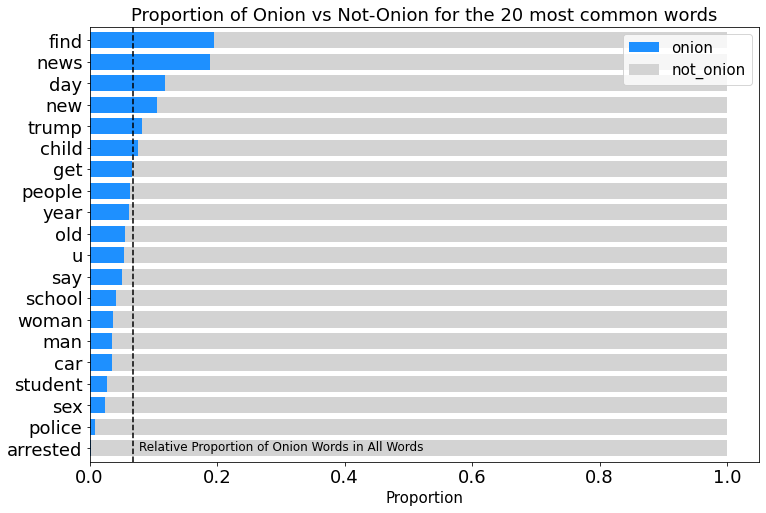

In [16]:
h_bar_proportions(word_counts, onion_words_df, all_words_df)

### Are there any words that uniquely identify an onion headline or a non-onion headline?

In [17]:
# Words that are unique to onion
word_counts[word_counts.not_onion == 0].sort_values(by='onion', ascending = False).head(10)

,all,onion,not_onion
0,,,
patriothole,29,29,0
clickventure,23,23,0
populace,6,6,0
dipshit,6,6,0
allocates,6,6,0
entirety,6,6,0
kotex,6,6,0
debase,5,5,0
giada,5,5,0


In [18]:
# Words that are unique to non-onion articles
word_counts[word_counts.onion == 0].sort_values(by='not_onion', ascending = False).head(10)

,all,onion,not_onion
0,,,
jailed,569,0,569
utah,428,0,428
cannabis,312,0,312
stabbed,308,0,308
mp,304,0,304
stabbing,248,0,248
according,219,0,219
gov,217,0,217
brawl,216,0,216


In [19]:
(word_counts
 [(word_counts.onion > 10) & (word_counts.not_onion > 10)]
 .assign(ratio=lambda df: df.onion / (df.not_onion + .01))
 .sort_values(by='ratio')
 .pipe(lambda df: pd.concat([df.head(3), df.tail(3)])))

,all,onion,not_onion,ratio
0,,,,
police,8918,69,8849,0.007797
texas,1378,11,1367,0.008047
florida,2147,20,2127,0.009403
fucking,146,99,47,2.105935
quiz,153,119,34,3.498971
finest,83,71,12,5.911740


Based on some of the most distinctly represented words in onion/not-onion headlines, onion headlines more commonly use the word quiz, likely because, as a site that relies solely on digital media, interactive pages are more commonly linked to onion related headlines than non-onion related headlines. 

The non-onion headlines often refer to 'florida'. I suspect that this is because of the meme nature of the bigram 'florida man'. 

### What does the distribution of IDFs look like for the most common words?

In [20]:
idf(all_words_df, train)

,word,total_count,num_of_documents,idf_value
0,man,18609,36001,1.591947
1,say,10712,11251,2.755037
2,woman,10615,10531,2.821171
3,police,8918,8835,2.996773
4,trump,7491,7333,3.183109
5,year,6452,6320,3.331775
6,new,6285,9803,2.892806
7,get,5171,7593,3.148267
8,u,4555,135226,0.268547
9,sex,3904,5621,3.448985


Because of the nature of headlines, it is unlikely for the total_count to be substantially different from the num_of_documents, as generally a headline will be made of mostly unique words. The IDF values for the top words supports this idea. The high IDF values still represent that the presence of these words are useful however. There are 176,886 documents in the train dataset, and the most common word shows up in less than 11% of them. A model that utilizes IDF or perhaps TF-IDF will likely have a strong predictive ability. 

### Does the length of the headline vary by source?

In [21]:
# Descriptive statistics of Onion headline document lengths
train[train.label == 1].doc_length.describe()

count    10995.000000
mean         9.149341
std          3.680416
min          1.000000
25%          7.000000
50%          9.000000
75%         11.000000
max         38.000000
Name: doc_length, dtype: float64

In [22]:
# Descriptive statistics of Non-onion headline document lengths
train[train.label == 0].doc_length.describe()

count    165889.000000
mean          8.362887
std           2.857322
min           1.000000
25%           7.000000
50%           8.000000
75%          10.000000
max          42.000000
Name: doc_length, dtype: float64

In [23]:
train.groupby('label').doc_length.mean()

label
0    8.362887
1    9.149341
Name: doc_length, dtype: float64

Onion headlines do appear to be slightly longer than non-onion headlines. We can validate this with a t-test.

$H_0$: There is no difference between the length of Onion and Non-onion headlines.  
$H_a$: Onion headlines are longer than Non-onion headlines.

In [24]:
alpha = 0.05
stat, p = stats.ttest_ind(train[train.label == 1]['doc_length'], train[train.label == 0]['doc_length'])
stat, p/2

(27.394130973839914, 3.569985460867351e-165)

In [25]:
if p/2 < alpha:
    print('We reject the null hypothesis. Based on the t-statistic, Onion headlines are longer than non-onion headlines.')
else:
    print('We fail to reject the null hypothesis.')

We reject the null hypothesis. Based on the t-statistic, Onion headlines are longer than non-onion headlines.


As we predicted, the length of Onion headlines are longer. Precisely why this is the case may be difficult to ascertain without extensive investigation of many journalists, but a simple possible explanation is that a number of Onion headlines are written in a conversational manner. As an example:

        "Wow: When Someone Graffitied Hateful Messages On This Mosque, A Group Of House Painters Came Together To Cover It Up For Free. But Then The Next Night The Hateful Guy Came Back And Wrote Even Worse Stuff, And The Painters Are Booked Through The End Of The Year. So Now Some Well-Intentioned [cont.]"
        
Best practices in journalism suggest avoiding an extended headline like the example above.

### Is there a difference in the number of stopwords removed?

In [26]:
# Descriptive statistics of Onion headline stopwords removed
train[train.label == 1].stopwords_removed.describe()

count    10995.000000
mean         4.475307
std          3.270282
min          0.000000
25%          2.000000
50%          4.000000
75%          6.000000
max         28.000000
Name: stopwords_removed, dtype: float64

In [27]:
# Descriptive statistics of Not-Onion headlines stopwords removed
train[train.label == 0].stopwords_removed.describe()

count    165889.000000
mean          3.283226
std           2.405572
min           0.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          33.000000
Name: stopwords_removed, dtype: float64

Onion headlines appear to have more stopwords than non-onion headlines. We can validate this with a t-test.

$H_0$: There is no difference between the number of stopwords in Onion and Non-onion headlines.  
$H_a$: Onion headlines contain more stopwords than Non-onion headlines.

In [28]:
alpha = 0.05
stat, p = stats.ttest_ind(train[train.label == 1]['stopwords_removed'], train[train.label == 0]['stopwords_removed'])
stat, p

(49.0449379728409, 0.0)

In [29]:
if p < alpha:
    print('We reject the null hypothesis. Onion headlines have more stopwords than non-onion headlines.')
else:
    print('We fail to reject the null hypothesis.')

We reject the null hypothesis. Onion headlines have more stopwords than non-onion headlines.


Not surprisingly, Onion headlines contain more stopwords. The conversational manner of many Onion headlines may be contributing to the increased use of stopwords. 

### How are the bigrams within the dataset distributed?

In [30]:
top_20_onion_bigrams = (pd.Series(nltk.ngrams(onion_words.split(), 2))
                       .value_counts()
                       .head(20))

top_20_onion_bigrams

(said, find)          270
(year, old)           134
(white, house)        108
(donald, trump)        76
(news, source)         73
(study, find)          73
(finest, news)         71
(america, finest)      71
(onion, america)       70
(need, know)           66
(everything, need)     59
(5, thing)             59
(thing, know)          58
(culture, shock)       55
(must, see)            54
(pope, francis)        46
(area, man)            45
(high, school)         44
(new, york)            44
(horoscope, week)      41
dtype: int64

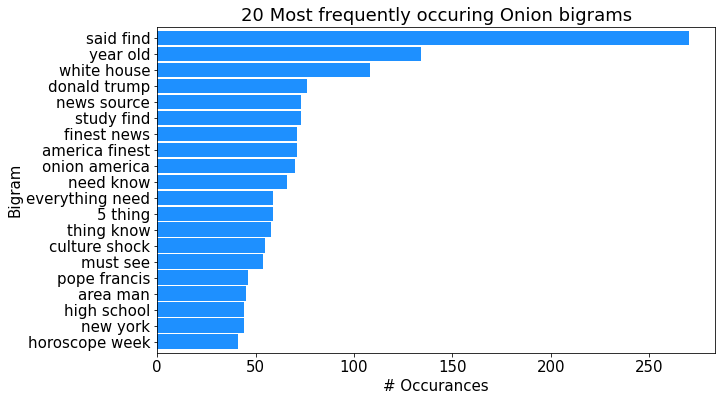

In [31]:
top_20_onion_bigrams.sort_values().plot.barh(color='dodgerblue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Onion bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_onion_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
labels = list(labels.values)
labels.reverse()
_ = plt.yticks(ticks, labels)

In [32]:
top_20_not_onion_bigrams = (pd.Series(nltk.ngrams(not_onion_words.split(), 2))
                           .value_counts()
                           .head(20))

top_20_not_onion_bigrams

(year, old)          3030
(donald, trump)      1415
(man, arrested)       933
(police, say)         906
(white, house)        759
(north, korea)        750
(covid, 19)           725
(new, york)           683
(high, school)        623
(police, officer)     592
(florida, man)        576
(x, post)             544
(post, r)             486
(fox, news)           475
(kim, jong)           463
(man, accused)        453
(jong, un)            450
(kanye, west)         377
(climate, change)     366
(trump, say)          360
dtype: int64

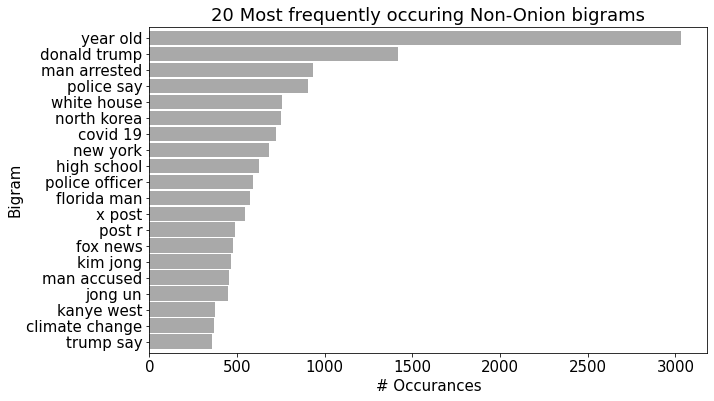

In [33]:
top_20_not_onion_bigrams.sort_values().plot.barh(color='darkgray', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Non-Onion bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_not_onion_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
labels = list(labels.values)
labels.reverse()
_ = plt.yticks(ticks, labels)

### Visualizing Bigrams in a Word Cloud

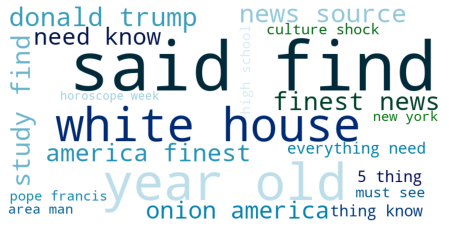

In [34]:
# Onion Bigram Word Cloud
data = {k[0] + ' ' + k[1]: v for k, v in top_20_onion_bigrams.to_dict().items()}
img = WordCloud(background_color='white', colormap='ocean', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

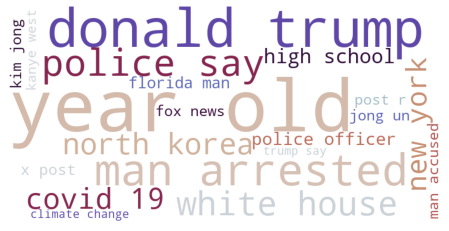

In [35]:
# Not-Onion Bigram Word Cloud
data = {k[0] + ' ' + k[1]: v for k, v in top_20_not_onion_bigrams.to_dict().items()}
img = WordCloud(background_color='white', colormap='twilight', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

### How are the trigrams within the dataset distributed?

In [36]:
top_20_onion_trigrams = (pd.Series(nltk.ngrams(onion_words.split(), 3))
                        .value_counts()
                        .head(20))

top_20_onion_trigrams

(finest, news, source)          71
(america, finest, news)         71
(onion, america, finest)        70
(everything, need, know)        59
(5, thing, know)                56
(week, picture, week)           38
(culture, shock, everything)    31
(shock, everything, need)       31
(change, way, watch)            22
(j, k, rowling)                 18
(culture, shock, culture)       17
(new, york, time)               17
(shock, culture, shock)         17
(onion, look, back)             15
(onion, present, topical)       15
(kim, jong, un)                 14
(plan, perfect, day)            13
(new, study, find)              13
(life, culture, shock)          12
(video, change, way)            12
dtype: int64

In [37]:
top_20_not_onion_trigrams = (pd.Series(nltk.ngrams(not_onion_words.split(), 3))
                        .value_counts()
                        .head(20))

top_20_not_onion_trigrams

(x, post, r)               474
(kim, jong, un)            448
(year, old, girl)          286
(year, old, boy)           253
(year, old, man)           157
(12, year, old)            151
(year, old, woman)         138
(11, year, old)            138
(13, year, old)            118
(10, year, old)            115
(new, york, city)          114
(year, old, son)           112
(14, year, old)            102
(high, school, student)     98
(black, life, matter)       96
(osama, bin, laden)         80
(read, http, www)           80
(george, w, bush)           78
(daily, flash, ad)          76
(nobel, peace, prize)       76
dtype: int64

# Modeling

## Resampling

Given the class imbalance of the dataset, we can likely improve the recall of our models by achieving greater parity between the number of onion headlines and not-onion headlines. There are several methods to accomplish this:

1. Random undersampling. We reduce the size of the train dataset by randomly eliminating rows that contain not-onion headlines until the number of onion headlines and not-onion headlines are equal. This is destructive, but we will evaluate it as an option for the purposes of this project. Generally, this technique should not be used in a production environment. 

1. Random oversampling. We take samples at random from the smaller class (onion headlines) and duplicate them until it reaches a size comparable with the majority class. This can also run into some overfitting issues, as we will be exaggerating small details within the onion headlines by a factor of 14-fold. 

1. SMOTE. We create synthetic samples along the line joining the current instance and some of its k nearest neighbors from the same class. This creates denser decision regions, and can help classifiers learn more from the dense regions of the minority class rather than defaulting to the large classes surrounding those regions. 

1. Shuffling or synonymous word replacement. A simple method is to create synthetic samples by shuffling the words around or by replacing the words with similar words. We will evaluate the use of translators to translate a word from english into another random language and then translate it back to english. This should create a slightly different headline, but one which has a context similar to the original headline. 

In [38]:
#Class count
count_class_0, count_class_1 = train.label.value_counts()
count_class_0, count_class_1

(165889, 10995)

In [39]:
# Divide train into two separate dataframes by label
train_class_0 = train[train.label == 0]
train_class_1 = train[train.label == 1]

In [40]:
train_class_0.shape, train_class_1.shape

((165889, 8), (10995, 8))

In [113]:
print('No Resampling Results')
print(train.label.value_counts())

No Resampling Results
0    165889
1     10995
Name: label, dtype: int64


### Random Undersampling

In [41]:
# Using the .sample method, we obtain a number of samples equal to the number of observations in the minority class
train_class_0_undersampled = train_class_0.sample(count_class_1, random_state=123)

# We concatenate this smaller sample of the majority class with our minority class dataframe
train_undersampled = pd.concat([train_class_0_undersampled, train_class_1], axis = 0)

print('Random Undersampling Results')
print(train_undersampled.label.value_counts())

Random Undersampling Results
1    10995
0    10995
Name: label, dtype: int64


### Random Oversampling

In [42]:
# Using the .sample method again, we can create a dataframe made of duplicated entries until the minority class has as many observations as the majority class
train_class_1_oversampled = train_class_1.sample(count_class_0, replace=True, random_state=123)

# We concatenate this larger sample of the minority class with our majority class dataframe
train_oversampled = pd.concat([train_class_0, train_class_1_oversampled], axis=0)

print('Random Oversampling Results')
print(train_oversampled.label.value_counts())

Random Oversampling Results
1    165889
0    165889
Name: label, dtype: int64


### Create Label Series (y)

y_train is tagged with '_original' to indicate that it is composed of the labels without any resampling techniques

Additional resampling techniques will create additional observations that will change the train derived labels. The labels for validate and test will not need to be adjusted, as they represent unseen data. 

In [43]:
y_train_original = train.label
y_train_undersampled = train_undersampled.label
y_train_oversampled = train_oversampled.label
y_validate = validate.label
y_test = test.label

### Create Prediction Dataframes
We we create a dataframe to store the predictions made by the various algorithms

In [44]:
train_results_original = pd.DataFrame(dict(actual=y_train_original))

In [45]:
train_results_original.value_counts()

actual
0         165889
1          10995
dtype: int64

In [46]:
train_results_undersampled = pd.DataFrame(dict(actual=y_train_undersampled))

In [47]:
train_results_undersampled.value_counts()

actual
1         10995
0         10995
dtype: int64

In [48]:
train_results_oversampled = pd.DataFrame(dict(actual=y_train_oversampled))

In [49]:
train_results_oversampled.value_counts()

actual
1         165889
0         165889
dtype: int64

### Create Baseline Model

The simplest baseline model will be developed using the majority class as 100% predicted.

In [50]:
train_results_original['baseline'] = train.label.value_counts().idxmax()
train_results_original

,actual,baseline
155599,0,0
123843,0,0
136828,0,0
203791,0,0
38167,0,0
...,...,...
56602,0,0
145965,0,0
107537,0,0
159344,0,0


In [51]:
train_results_original.baseline.value_counts()

0    176884
Name: baseline, dtype: int64

In [52]:
baseline_f1_score_original = round(f1_score(train_results_original.actual, train_results_original.baseline), 3)
baseline_accuracy_original = round(accuracy_score(train_results_original.actual, train_results_original.baseline), 3)

In [53]:
print('Baseline Model Confusion Matrix')
pd.crosstab(train_results_original.baseline, train_results_original.actual)

Baseline Model Confusion Matrix


actual,0,1
baseline,,
0,165889,10995


In [54]:
print('Baseline Model: Majority Class Predicted')
print(f'Accuracy: {baseline_accuracy_original}')
print(f'f1_score: {baseline_f1_score_original}')
print('---')
print(classification_report(train_results_original.actual, train_results_original.baseline))

Baseline Model: Majority Class Predicted
Accuracy: 0.938
f1_score: 0.0
---
              precision    recall  f1-score   support

           0       0.94      1.00      0.97    165889
           1       0.00      0.00      0.00     10995

    accuracy                           0.94    176884
   macro avg       0.47      0.50      0.48    176884
weighted avg       0.88      0.94      0.91    176884



Naturally, accuracy is high because of the substantial proportion of not-onion headlines in the dataset, but recall on this model for onion articles is zero. Our goal will be to increase recall while still maintaining reasonable accuracy overall. The f1_score is a good measure for this. 

Given the amount of modification we are performing on our train with resampling, the current accuracy on the training data is not particularly important. The metrics on the validate data sample will be more telling. 

## Vectorization Methods

### Vectorization
To begin, we will need to generate numerical representations of the text data. There are a number of methods:

1. Bag of Words - This generates a number of features equal to the total number of unique words in the corpus (all of our headlines combined). The features for each document (headline) are given values equal to the number of occurences for those words in the document. This relatively simple approach may be limited because:
    - The headlines are relatively short (around 8 words long)
    - The headlines tend to be composed of almost entirely unique words
    
    
2. Term Frequency Inverse Document Frequency (TF-IDF) - This measures how important a word is to a document. We compute the term frequency (how often a word is used overall) and the inverse document frequency (how many documents that word is used in) and combine them to create a score that increases the relative value given to a rarer and more specific word. 
    - Looking at the IDF scores from earlier, it appears that many of the words have a high IDF score. 
    - This is likely to outperform a bag of words model
    
    
3. Global Vectors for Word Representation (GloVe) - This is an unsupervised learning algorithm for obtaining vector representations for words. Each word in the corpus is transformed into a position in high dimensional space so that similar words are placed together. There are pretrained GloVe values available for download, and for the purposes of this project, the Wikipedia 2014 + Gigaword 5 vectors available from https://nlp.stanford.edu/projects/glove/ will be used.


4. word2vec - This vectorizes words through use of a neural network to evaluate the context of a given word in a document by two methods: CBoW (continuous bag of words), which tries to predict the context of the word by looking at its surrounding words, and Skipgram, which tries to predict the context of the surrounding words by looking at the current word. There is also an extension of word2vec called doc2vec that adds another layer which corresponds to paragraph representation, but given the short length of the documents in this dataset, adding the doc2vec sophistication will not likely yield much improvement over word2vec.


5. Fasttext - This is a library developed by the Facebook Research Team that utilizes word2vec methodology but introduces char n-grams that improve the ability to learn and adequately vectorize rare words. 

For now, we will focus on Bag of Words and Term Frequency Inverse Document Frequency for our text vectorization methods and will return to GloVe, word2vec, and Fasttext if there is time.

### --== Bag of Words ==--
### Bag of Words Vectorization - No Resampling

In [55]:
# Create the vectorizer object
bow_vectorizer = CountVectorizer(analyzer = 'word', tokenizer = None, preprocessor = None, stop_words = None)

In [56]:
# Pass the cleaned headlines into the .fit_transform method
X_train_bow_original = bow_vectorizer.fit_transform(train.clean)
X_train_bow_original

<176884x50989 sparse matrix of type '<class 'numpy.int64'>'
	with 1455679 stored elements in Compressed Sparse Row format>

In [57]:
# Confirm that all headlines were vectorized
train.shape

(176884, 8)

There are 50989 columns in our bag of words array. This corresponds to 50989 unique words each given a value for being present or absent in a given headline

In [58]:
# We can inspect a sample of the feature names to view some of the vocabulary used in the corpus
vocab = bow_vectorizer.get_feature_names()
vocab[20000:20010]

['grandstander',
 'grandville',
 'grange',
 'granite',
 'grannie',
 'granny',
 'granola',
 'grant',
 'granted',
 'grantham']

### Bag of Words Vectorization - Random Undersampling

In [59]:
# Create the vectorizer object
bow_vectorizer_undersampled = CountVectorizer(analyzer = 'word', tokenizer = None, preprocessor = None, stop_words = None)

In [60]:
# Pass the cleaned headlines into the .fit_transform method
X_train_bow_undersampled = bow_vectorizer_undersampled.fit_transform(train_undersampled.clean)
X_train_bow_undersampled

<21990x22179 sparse matrix of type '<class 'numpy.int64'>'
	with 188211 stored elements in Compressed Sparse Row format>

In [61]:
# Confirm that all headlines were vectorized
train_undersampled.shape

(21990, 8)

There are 22179 columns in our undersampled bag of words array. The number of unique words has been reduced to about 40% of its original amount. This represents real loss in information, and may cause issues when we move to validation.

In [62]:
# We can inspect a sample of the feature names to view some of the vocabulary used in the corpus
vocab_undersampled = bow_vectorizer_undersampled.get_feature_names()
vocab_undersampled[8692:8702]

['graffitied',
 'graham',
 'grail',
 'grain',
 'gram',
 'grammar',
 'grammer',
 'grammy',
 'grammys',
 'grand']

### Bag of Words Vectorization - Random Oversampling

In [63]:
# Create the vectorizer object
bow_vectorizer_oversampled = CountVectorizer(analyzer = 'word', tokenizer = None, preprocessor = None, stop_words = None)

In [64]:
# Pass the cleaned headlines into the .fit_transform method
X_train_bow_oversampled = bow_vectorizer_oversampled.fit_transform(train_oversampled.clean)
X_train_bow_oversampled

<331778x50989 sparse matrix of type '<class 'numpy.int64'>'
	with 2843442 stored elements in Compressed Sparse Row format>

In [65]:
# Confirm that all headlines were vectorized
train_oversampled.shape

(331778, 8)

Notice that while the total number of observations have increased, the number of features remained the same, as no new unique words were added in the process.

In [66]:
# We can inspect a sample of the feature names to view some of the vocabulary used in the corpus
vocab_oversampled = bow_vectorizer_oversampled.get_feature_names()
vocab_oversampled[20000:20010]

['grandstander',
 'grandville',
 'grange',
 'granite',
 'grannie',
 'granny',
 'granola',
 'grant',
 'granted',
 'grantham']

### --==TF-IDF==--
### TF-IDF Vectorization - No Resampling

In [67]:
# Create the vectorizer object
tfidf_vectorizer = TfidfVectorizer()

In [68]:
# Pass the cleaned headlines into the .fit_transform method
X_train_tfidf_original = tfidf_vectorizer.fit_transform(train.clean)
X_train_tfidf_original

<176884x50989 sparse matrix of type '<class 'numpy.float64'>'
	with 1455679 stored elements in Compressed Sparse Row format>

In [69]:
# Confirm all headlines were vectorized
train.shape

(176884, 8)

There are 50989 columns in our bag of words array. This corresponds to 50989 unique words each given a value for being present or absent in a given headline

In [70]:
# We can inspect a sample of the feature names to view some of the vocabulary used in the corpus
vocab = tfidf_vectorizer.get_feature_names()
vocab[20000:20010]

['grandstander',
 'grandville',
 'grange',
 'granite',
 'grannie',
 'granny',
 'granola',
 'grant',
 'granted',
 'grantham']

### TF-IDF Vectorization - Random Undersampling 

In [71]:
# Create the vectorizer object
tfidf_vectorizer_undersampled = TfidfVectorizer()

In [72]:
# Pass the cleaned headlines into the .fit_transform method
X_train_tfidf_undersampled = tfidf_vectorizer_undersampled.fit_transform(train_undersampled.clean)
X_train_tfidf_undersampled

<21990x22179 sparse matrix of type '<class 'numpy.float64'>'
	with 188211 stored elements in Compressed Sparse Row format>

In [73]:
# Confirm all headlines were vectorized
train_undersampled.shape

(21990, 8)

In [74]:
# We can inspect a sample of the feature names to view some of the vocabulary used in the corpus
vocab_undersampled = tfidf_vectorizer_undersampled.get_feature_names()
vocab_undersampled[8692:8702]

['graffitied',
 'graham',
 'grail',
 'grain',
 'gram',
 'grammar',
 'grammer',
 'grammy',
 'grammys',
 'grand']

### TF-IDF Vectorization - Random Oversampling

In [75]:
# Create the vectorizer object
tfidf_vectorizer_oversampled = TfidfVectorizer()

In [76]:
# Pass the cleaned headlines into the .fit_transform method
X_train_tfidf_oversampled = tfidf_vectorizer_oversampled.fit_transform(train_oversampled.clean)
X_train_tfidf_oversampled

<331778x50989 sparse matrix of type '<class 'numpy.float64'>'
	with 2843442 stored elements in Compressed Sparse Row format>

In [77]:
# Confirm all headlines were vectorized
train_oversampled.shape

(331778, 8)

In [78]:
# We can inspect a sample of the feature names to view some of the vocabulary used in the corpus
vocab_oversampled = tfidf_vectorizer_oversampled.get_feature_names()
vocab_oversampled[20000:20010]

['grandstander',
 'grandville',
 'grange',
 'granite',
 'grannie',
 'granny',
 'granola',
 'grant',
 'granted',
 'grantham']

### --==doc2vec==--
### doc2vec Vectorization - No Resampling

In [114]:
#Tag the headline text
headline_docs = [TaggedDocument(doc.split(' '), [i]) for i, doc in enumerate(train.clean)]

In [116]:
headline_docs[:3]

[TaggedDocument(words=['passenger', 'claiming', 'government', 'experimented', 'try', 'open', 'plane', 'door', 'mid', 'flight', 'witness'], tags=[0]),
 TaggedDocument(words=['mumbai', 'rat', 'ate', 'ketamine', 'say', 'sewri', 'police'], tags=[1]),
 TaggedDocument(words=['novelist', 'wrote', 'murder', 'husband', 'charged', 'murdering', 'husband'], tags=[2])]

In [119]:
#instantiate model
doc2vec_model = Doc2Vec(vector_size=64, window=2, min_count=1, workers=8, epochs=40)

In [120]:
#build vocab
doc2vec_model.build_vocab(headline_docs)

In [ ]:
# pass the cleaned text into the model to generate vectors for each document
X_train_doc2vec_original = [doc2vec_model.infer_vector((train.clean[i].split(' '))) for i in train.clean.index]

In [131]:
X_train_doc2vec_original[0]

array([-0.00754144,  0.00079369,  0.00307168, -0.00369847, -0.00758717,
       -0.00177516, -0.00653354, -0.00314811,  0.00439993,  0.00243848,
       -0.00341261, -0.00361993, -0.00420397, -0.00053239,  0.00606593,
        0.00511282,  0.00461906, -0.00240125, -0.00569281, -0.00439907,
       -0.00010561, -0.00489332,  0.0054203 , -0.00284829, -0.00462528,
        0.00743075, -0.00118312,  0.00053653,  0.0064165 , -0.00095037,
        0.00082449,  0.00012698,  0.00712287,  0.00351032,  0.00599313,
        0.00653554, -0.002975  , -0.00123568,  0.0025034 , -0.00245834,
        0.00280161,  0.00134894, -0.00486873, -0.00238053,  0.00296454,
       -0.00010042,  0.00558445, -0.00342998, -0.00378133,  0.00224996,
       -0.00043215, -0.00283693, -0.00386629, -0.00365221, -0.00670185,
        0.00241848,  0.00676024,  0.00715019,  0.00671816, -0.00551961,
        0.00708858, -0.00225492,  0.00349983, -0.00766045], dtype=float32)

In [129]:
# Confirm all observations were vectorized
len(X_train_doc2vec_original), train.shape

(176884, (176884, 8))

### doc2vec Vectorization - Random Undersampling

In [132]:
#Tag the headline text
headline_docs_undersampled = [TaggedDocument(doc.split(' '), [i]) for i, doc in enumerate(train_undersampled.clean)]

In [133]:
headline_docs_undersampled[:3]

[TaggedDocument(words=['president', 'trump', 'cite', 'china', 'respect', 'large', 'brain'], tags=[0]),
 TaggedDocument(words=['proof', 'needed', 'lululemon', 'see', 'yoga', 'pant', 'refund'], tags=[1]),
 TaggedDocument(words=['17', 'year', 'old', 'girl', 'struck', 'lightning', 'masturbating'], tags=[2])]

In [134]:
#instantiate model
doc2vec_model_undersampled = Doc2Vec(vector_size=64, window=2, min_count=1, workers=8, epochs=40)

In [135]:
#build vocab
doc2vec_model_undersampled.build_vocab(headline_docs_undersampled)

In [136]:
# pass the cleaned text into the model to generate vectors for each document
X_train_doc2vec_undersampled = [doc2vec_model_undersampled.infer_vector((train.clean[i].split(' '))) for i in train_undersampled.clean.index]

In [137]:
X_train_doc2vec_undersampled[0]

array([-0.00479046, -0.00707462,  0.00727444, -0.00516517,  0.00155099,
        0.00054285,  0.00421446, -0.00238313, -0.00401413,  0.00272418,
       -0.00336488, -0.00641119, -0.00528481,  0.00666566,  0.00590716,
        0.00572617, -0.00572913,  0.00184702, -0.00569791,  0.00288517,
        0.00114904, -0.00409128, -0.00075165,  0.00012018,  0.00290819,
        0.00539087, -0.0062914 , -0.00757429, -0.00731116,  0.00758309,
        0.00169341, -0.00268401, -0.00480238, -0.00723599, -0.00155552,
       -0.00168877, -0.00720394,  0.00112165, -0.00618802, -0.00776932,
       -0.00764285,  0.00718781,  0.00380074,  0.00021564, -0.00445162,
       -0.00298732,  0.00358855, -0.00205616, -0.0072496 ,  0.00228967,
       -0.00311212, -0.00274777, -0.00741545,  0.00578616,  0.00393239,
       -0.00470694,  0.00070173,  0.00311599, -0.00335352, -0.00314739,
        0.00525315,  0.0001134 ,  0.00668855,  0.00142009], dtype=float32)

In [138]:
# Confirm all observations were vectorized
len(X_train_doc2vec_undersampled), train_undersampled.shape

(21990, (21990, 8))

### doc2vec Vectorization - Random Oversampling

In [139]:
#Tag the headline text
headline_docs_oversampled = [TaggedDocument(doc.split(' '), [i]) for i, doc in enumerate(train_oversampled.clean)]

In [140]:
headline_docs_oversampled[:3]

[TaggedDocument(words=['passenger', 'claiming', 'government', 'experimented', 'try', 'open', 'plane', 'door', 'mid', 'flight', 'witness'], tags=[0]),
 TaggedDocument(words=['mumbai', 'rat', 'ate', 'ketamine', 'say', 'sewri', 'police'], tags=[1]),
 TaggedDocument(words=['novelist', 'wrote', 'murder', 'husband', 'charged', 'murdering', 'husband'], tags=[2])]

In [141]:
#instantiate model
doc2vec_model_oversampled = Doc2Vec(vector_size=64, window=2, min_count=1, workers=8, epochs=40)

In [142]:
#build vocab
doc2vec_model_oversampled.build_vocab(headline_docs_oversampled)

In [143]:
# pass the cleaned text into the model to generate vectors for each document
X_train_doc2vec_oversampled = [doc2vec_model_oversampled.infer_vector((train.clean[i].split(' '))) for i in train_oversampled.clean.index]

In [144]:
X_train_doc2vec_oversampled[0]

array([-0.00754144,  0.00079369,  0.00307168, -0.00369847, -0.00758717,
       -0.00177516, -0.00653354, -0.00314811,  0.00439993,  0.00243848,
       -0.00341261, -0.00361993, -0.00420397, -0.00053239,  0.00606593,
        0.00511282,  0.00461906, -0.00240125, -0.00569281, -0.00439907,
       -0.00010561, -0.00489332,  0.0054203 , -0.00284829, -0.00462528,
        0.00743075, -0.00118312,  0.00053653,  0.0064165 , -0.00095037,
        0.00082449,  0.00012698,  0.00712287,  0.00351032,  0.00599313,
        0.00653554, -0.002975  , -0.00123568,  0.0025034 , -0.00245834,
        0.00280161,  0.00134894, -0.00486873, -0.00238053,  0.00296454,
       -0.00010042,  0.00558445, -0.00342998, -0.00378133,  0.00224996,
       -0.00043215, -0.00283693, -0.00386629, -0.00365221, -0.00670185,
        0.00241848,  0.00676024,  0.00715019,  0.00671816, -0.00551961,
        0.00708858, -0.00225492,  0.00349983, -0.00766045], dtype=float32)

In [145]:
# Confirm all observations were vectorized
len(X_train_doc2vec_oversampled), train_oversampled.shape

(331778, (331778, 8))

## Algorithm Selection

Now that we have multiple sets of train data based on our resampling methods, and multiple set of vectorized train data, we can develop models based on any number of classification algorithms. In this case, we will work with:
1. Logistic Regression
2. Decision Tree
3. Random Forest
4. K-Nearest Neighbors

### --==Logistic Regression==--

### Logistic Regression with Bag of Words Vectorization (No Resampling)

Logistic Regression will give each observation a probability of being from r/TheOnion or r/NotTheOnion. The highest probability will determine the predicted label.

In [79]:
logit_bow_original = LogisticRegression().fit(X_train_bow_original, y_train_original)

In [80]:
train_results_original['logit_bow'] = logit_bow_original.predict(X_train_bow_original)
train_results_original

,actual,baseline,logit_bow
155599,0,0,0
123843,0,0,0
136828,0,0,0
203791,0,0,0
38167,0,0,0
...,...,...,...
56602,0,0,0
145965,0,0,0
107537,0,0,0
159344,0,0,0


In [81]:
logit_bow_accuracy_original = round(accuracy_score(train_results_original.actual, train_results_original.logit_bow))
logit_bow_f1_score_original = round(f1_score(train_results_original.actual, train_results_original.logit_bow))

In [82]:
print('Logistic Regression - Bag of Words (No Resampling) Model Confusion Matrix')
pd.crosstab(train_results_original.logit_bow, train_results_original.actual)

Logistic Regression - Bag of Words (No Resampling) Model Confusion Matrix


actual,0,1
logit_bow,,
0,165382,5580
1,507,5415


In [83]:
print('Logistic Regression - Bag of Words (No Resampling) Model')
print(f'Accuracy: {logit_bow_accuracy_original}')
print(f'f1_score: {logit_bow_f1_score_original}')
print('---')
print(classification_report(train_results_original.actual, train_results_original.logit_bow))

Logistic Regression - Bag of Words (No Resampling) Model
Accuracy: 1
f1_score: 1
---
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    165889
           1       0.91      0.49      0.64     10995

    accuracy                           0.97    176884
   macro avg       0.94      0.74      0.81    176884
weighted avg       0.96      0.97      0.96    176884



#### Takeaways: Logistic Regression - Bag of Words (No Resampling) Train Performance
- Compared to baseline, our model was able to increase overall accuracy by 3%
- More importantly, we were able to increase our recall of the minority class from 0 to 49%, leading to a subsequent increase in f1 score to 64%
- This model is able to accurately predict Onion headlines about half of the time, and it only misrepresents a Not-onion headline 0.3% of the time. 

### Logistic Regression with Bag of Words (Random Undersampling)

In [84]:
logit_bow_undersampled = LogisticRegression().fit(X_train_bow_undersampled, y_train_undersampled)

In [85]:
train_results_undersampled['logit_bow'] = logit_bow_undersampled.predict(X_train_bow_undersampled)
train_results_undersampled

,actual,logit_bow
254363,0,0
224243,0,0
138197,0,0
173522,0,0
63963,0,0
...,...,...
16089,1,1
9580,1,1
2267,1,1
1134,1,1


In [86]:
logit_bow_accuracy_undersampled = round(accuracy_score(train_results_undersampled.actual, train_results_undersampled.logit_bow), 3)
logit_bow_f1_score_undersampled = round(f1_score(train_results_undersampled.actual, train_results_undersampled.logit_bow), 3)

In [87]:
print('Logistic Regression - Bag of Words (Random Undersampling) Model Confusion Matrix')
pd.crosstab(train_results_undersampled.logit_bow, train_results_undersampled.actual)

Logistic Regression - Bag of Words (Random Undersampling) Model Confusion Matrix


actual,0,1
logit_bow,,
0,10369,702
1,626,10293


In [88]:
print('Logistic Regression - Bag of Words (Random Undersampling) Model')
print(f'Accuracy: {logit_bow_accuracy_undersampled}')
print(f'f1_score: {logit_bow_f1_score_undersampled}')
print('---')
print(classification_report(train_results_undersampled.actual, train_results_undersampled.logit_bow))

Logistic Regression - Bag of Words (Random Undersampling) Model
Accuracy: 0.94
f1_score: 0.939
---
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     10995
           1       0.94      0.94      0.94     10995

    accuracy                           0.94     21990
   macro avg       0.94      0.94      0.94     21990
weighted avg       0.94      0.94      0.94     21990



#### Takeways:
- Although our accuracy has dropped, our recall and f1_score for Onion predictions have improved substantially. 
- Nevertheless, we lost almost 30,000 unique words when we reduced our data, and this may have real consequences when we validate this model against unseen data

### Logistic Regression with Bag of Words Vectorization (Random Oversampling)

In [89]:
logit_bow_oversampled = LogisticRegression().fit(X_train_bow_oversampled, y_train_oversampled)

In [90]:
train_results_oversampled['logit_bow'] = logit_bow_oversampled.predict(X_train_bow_oversampled)
train_results_oversampled

,actual,logit_bow
155599,0,0
123843,0,0
136828,0,0
203791,0,0
38167,0,0
...,...,...
1311,1,1
8625,1,1
7051,1,1
5342,1,1


In [91]:
logit_bow_accuracy_oversampled = round(accuracy_score(train_results_oversampled.actual, train_results_oversampled.logit_bow), 3)
logit_bow_f1_score_oversampled = round(f1_score(train_results_oversampled.actual, train_results_oversampled.logit_bow), 3)

In [92]:
print('Logistic Regression - Bag of Words (Random Oversampling) Model Confusion Matrix')
pd.crosstab(train_results_oversampled.logit_bow, train_results_oversampled.actual)

Logistic Regression - Bag of Words (Random Oversampling) Model Confusion Matrix


actual,0,1
logit_bow,,
0,154616,5241
1,11273,160648


In [93]:
print('Logistic Regression - Bag of Words (Random Oversampling) Model')
print(f'Accuracy: {logit_bow_accuracy_oversampled}')
print(f'f1_score: {logit_bow_f1_score_oversampled}')
print('---')
print(classification_report(train_results_oversampled.actual, train_results_oversampled.logit_bow))

Logistic Regression - Bag of Words (Random Oversampling) Model
Accuracy: 0.95
f1_score: 0.951
---
              precision    recall  f1-score   support

           0       0.97      0.93      0.95    165889
           1       0.93      0.97      0.95    165889

    accuracy                           0.95    331778
   macro avg       0.95      0.95      0.95    331778
weighted avg       0.95      0.95      0.95    331778



#### Takeaways:
- Oversampling resulted in a marginal increase in both accuracy and f1 score compared to undersampling. 
- Recall on Onion headlines improved at the expense of Not-Onion headlines when compared to undersampling.
- There is far less information loss compared to undersampling with comparable performance on train. 
- Validation step is still very important, as this may be overfit due to the magnification of the specific unique words used in the Onion headlines in this training data. 

### Logistic Regression with TF-IDF Vectorization (No Resampling)

In [94]:
logit_tfidf_original = LogisticRegression().fit(X_train_tfidf_original, y_train_original)

In [95]:
train_results_original['logit_tfidf'] = logit_tfidf_original.predict(X_train_tfidf_original)
train_results_original

,actual,baseline,logit_bow,logit_tfidf
155599,0,0,0,0
123843,0,0,0,0
136828,0,0,0,0
203791,0,0,0,0
38167,0,0,0,0
...,...,...,...,...
56602,0,0,0,0
145965,0,0,0,0
107537,0,0,0,0
159344,0,0,0,0


In [96]:
logit_tfidf_accuracy_original = round(accuracy_score(train_results_original.actual, train_results_original.logit_tfidf))
logit_tfidf_f1_score_original = round(f1_score(train_results_original.actual, train_results_original.logit_tfidf))

In [97]:
print('Logistic Regression - TFIDF (No Resampling) Model Confusion Matrix')
pd.crosstab(train_results_original.logit_tfidf, train_results_original.actual)

Logistic Regression - TFIDF (No Resampling) Model Confusion Matrix


actual,0,1
logit_tfidf,,
0,165508,8489
1,381,2506


In [98]:
print('Logistic Regression - TF-IDF (No Resampling) Model')
print(f'Accuracy: {logit_tfidf_accuracy_original}')
print(f'f1_score: {logit_tfidf_f1_score_original}')
print('---')
print(classification_report(train_results_original.actual, train_results_original.logit_tfidf))

Logistic Regression - TF-IDF (No Resampling) Model
Accuracy: 1
f1_score: 0
---
              precision    recall  f1-score   support

           0       0.95      1.00      0.97    165889
           1       0.87      0.23      0.36     10995

    accuracy                           0.95    176884
   macro avg       0.91      0.61      0.67    176884
weighted avg       0.95      0.95      0.94    176884



#### Takeaways:
- The TF-IDF vectorization on the original train data produced inferior results to the bag of words vectorization on the original train data.
- Both accuracy and recall were reduced with TF-IDF compared to BoW, without only 23% of Onion articles correctly classified.

### Logistic Regression with TF-IDF Vectorization (Random Undersampling)

In [99]:
logit_tfidf_undersampled = LogisticRegression().fit(X_train_tfidf_undersampled, y_train_undersampled)

In [100]:
train_results_undersampled['logit_tfidf'] = logit_tfidf_undersampled.predict(X_train_tfidf_undersampled)
train_results_undersampled

,actual,logit_bow,logit_tfidf
254363,0,0,0
224243,0,0,0
138197,0,0,0
173522,0,0,0
63963,0,0,0
...,...,...,...
16089,1,1,1
9580,1,1,1
2267,1,1,1
1134,1,1,1


In [101]:
logit_tfidf_accuracy_undersampled = round(accuracy_score(train_results_undersampled.actual, train_results_undersampled.logit_tfidf), 3)
logit_tfidf_f1_score_undersampled = round(f1_score(train_results_undersampled.actual, train_results_undersampled.logit_tfidf), 3)

In [102]:
print('Logistic Regression - TFIDF (Random Undersampling) Model Confusion Matrix')
pd.crosstab(train_results_undersampled.logit_tfidf, train_results_undersampled.actual)

Logistic Regression - TFIDF (Random Undersampling) Model Confusion Matrix


actual,0,1
logit_tfidf,,
0,9838,1252
1,1157,9743


In [103]:
print('Logistic Regression - TF-IDF (Random Undersampling) Model')
print(f'Accuracy: {logit_tfidf_accuracy_undersampled}')
print(f'f1_score: {logit_tfidf_f1_score_undersampled}')
print('---')
print(classification_report(train_results_undersampled.actual, train_results_undersampled.logit_tfidf))

Logistic Regression - TF-IDF (Random Undersampling) Model
Accuracy: 0.89
f1_score: 0.89
---
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     10995
           1       0.89      0.89      0.89     10995

    accuracy                           0.89     21990
   macro avg       0.89      0.89      0.89     21990
weighted avg       0.89      0.89      0.89     21990



#### Takeaways:
- Compared to TF-IDF with no resampling, undersampling the majority class drastically improved performance in predicting the minority class (at some expense to the majority). 
- While undersampling is generally not ideal, this much of an increase is still valuable, despite loss of data, if the overall accuracy is less important than the recall of predicting the minority class. 

### Logistic Regression with TF-IDF Vectorization (Random Oversampling)

In [104]:
logit_tfidf_oversampled = LogisticRegression().fit(X_train_tfidf_oversampled, y_train_oversampled)

In [105]:
train_results_oversampled['logit_tfidf'] = logit_tfidf_oversampled.predict(X_train_tfidf_oversampled)
train_results_oversampled

,actual,logit_bow,logit_tfidf
155599,0,0,0
123843,0,0,0
136828,0,0,0
203791,0,0,0
38167,0,0,0
...,...,...,...
1311,1,1,1
8625,1,1,1
7051,1,1,1
5342,1,1,1


In [106]:
logit_tfidf_accuracy_oversampled = round(accuracy_score(train_results_oversampled.actual, train_results_oversampled.logit_tfidf), 3)
logit_tfidf_f1_score_oversampled = round(f1_score(train_results_oversampled.actual, train_results_oversampled.logit_tfidf), 3)

In [107]:
print('Logistic Regression - TFIDF (Random Oversampling) Model Confusion Matrix')
pd.crosstab(train_results_oversampled.logit_tfidf, train_results_oversampled.actual)

Logistic Regression - TFIDF (Random Oversampling) Model Confusion Matrix


actual,0,1
logit_tfidf,,
0,150860,7518
1,15029,158371


In [108]:
print('Logistic Regression - TF-IDF (Random Oversampling) Model')
print(f'Accuracy: {logit_tfidf_accuracy_oversampled}')
print(f'f1_score: {logit_tfidf_f1_score_oversampled}')
print('---')
print(classification_report(train_results_oversampled.actual, train_results_oversampled.logit_tfidf))

Logistic Regression - TF-IDF (Random Oversampling) Model
Accuracy: 0.932
f1_score: 0.934
---
              precision    recall  f1-score   support

           0       0.95      0.91      0.93    165889
           1       0.91      0.95      0.93    165889

    accuracy                           0.93    331778
   macro avg       0.93      0.93      0.93    331778
weighted avg       0.93      0.93      0.93    331778



#### Takeaways:
- At the cost of just two points of accuracy, oversampling shows the best f1-scores for the TF-IDF based logistic regression models. 
- While this model still has inferior performance to the Bag of Words based Logistic Regression models, these numbers are competitive with the best of those models. 

### Logistic Regression with doc2vec Vectorization (No Resampling)

In [146]:
logit_doc2vec_original = LogisticRegression().fit(X_train_doc2vec_original, y_train_original)

In [147]:
train_results_original['logit_doc2vec'] = logit_doc2vec_original.predict(X_train_doc2vec_original)
train_results_original

,actual,baseline,logit_bow,logit_tfidf,logit_doc2vec
155599,0,0,0,0,0
123843,0,0,0,0,0
136828,0,0,0,0,0
203791,0,0,0,0,0
38167,0,0,0,0,0
...,...,...,...,...,...
56602,0,0,0,0,0
145965,0,0,0,0,0
107537,0,0,0,0,0
159344,0,0,0,0,0


In [167]:
logit_doc2vec_accuracy_original = round(accuracy_score(train_results_original.actual, train_results_original.logit_doc2vec), 3)
logit_doc2vec_f1_score_original = round(f1_score(train_results_original.actual, train_results_original.logit_doc2vec), 3)

In [168]:
print('Logistic Regression - doc2vec (No Resampling) Model Confusion Matrix')
pd.crosstab(train_results_original.logit_doc2vec, train_results_original.actual)

Logistic Regression - doc2vec (No Resampling) Model Confusion Matrix


actual,0,1
logit_doc2vec,,
0,165889,10995


In [169]:
print('Logistic Regression - doc2vec (No Resampling) Model')
print(f'Accuracy: {logit_doc2vec_accuracy_original}')
print(f'f1_score: {logit_doc2vec_f1_score_original}')
print('---')
print(classification_report(train_results_original.actual, train_results_original.logit_doc2vec))

Logistic Regression - doc2vec (No Resampling) Model
Accuracy: 0.938
f1_score: 0.0
---
              precision    recall  f1-score   support

           0       0.94      1.00      0.97    165889
           1       0.00      0.00      0.00     10995

    accuracy                           0.94    176884
   macro avg       0.47      0.50      0.48    176884
weighted avg       0.88      0.94      0.91    176884



#### Takeaways:
- Unfortunately, the doc2vec model performed identical to baseline. It was unable to capture any Onion articles, and is therefore useless.

### Logistic Regression with doc2vec Vectorization (Random Undersampling)

In [151]:
logit_doc2vec_undersampled = LogisticRegression().fit(X_train_doc2vec_undersampled, y_train_undersampled)

In [152]:
train_results_undersampled['logit_doc2vec'] = logit_doc2vec_undersampled.predict(X_train_doc2vec_undersampled)
train_results_undersampled

,actual,logit_bow,logit_tfidf,logit_doc2vec
254363,0,0,0,1
224243,0,0,0,1
138197,0,0,0,0
173522,0,0,0,1
63963,0,0,0,1
...,...,...,...,...
16089,1,1,1,1
9580,1,1,1,0
2267,1,1,1,0
1134,1,1,1,0


In [157]:
logit_doc2vec_accuracy_undersampled = round(accuracy_score(train_results_undersampled.actual, train_results_undersampled.logit_doc2vec), 3)
logit_doc2vec_f1_score_undersampled = round(f1_score(train_results_undersampled.actual, train_results_undersampled.logit_doc2vec), 3)

In [163]:
print('Logistic Regression - doc2vec (Random Undersampling) Model Confusion Matrix')
pd.crosstab(train_results_undersampled.logit_doc2vec, train_results_undersampled.actual)

Logistic Regression - doc2vec (Random Undersampling) Model Confusion Matrix


actual,0,1
logit_doc2vec,,
0,5758,5274
1,5237,5721


In [159]:
print('Logistic Regression - doc2vec (Random Undersampling) Model')
print(f'Accuracy: {logit_doc2vec_accuracy_undersampled}')
print(f'f1_score: {logit_doc2vec_f1_score_undersampled}')
print('---')
print(classification_report(train_results_undersampled.actual, train_results_undersampled.logit_doc2vec))

Logistic Regression - doc2vec (Random Undersampling) Model
Accuracy: 0.522
f1_score: 0.521
---
              precision    recall  f1-score   support

           0       0.52      0.52      0.52     10995
           1       0.52      0.52      0.52     10995

    accuracy                           0.52     21990
   macro avg       0.52      0.52      0.52     21990
weighted avg       0.52      0.52      0.52     21990



#### Takeaways:
- Rather surprisingly, the doc2vec using undersampled data performed abysmally. Granted, a baseline model would only have a 50% accuracy, so doc2vec improved upon the baseline, but the overall f1-score for Onion headlines is very low. 

### Logistic Regression with doc2vec Vectorization (Random Oversampling)

In [160]:
logit_doc2vec_oversampled = LogisticRegression().fit(X_train_doc2vec_oversampled, y_train_oversampled)

In [161]:
train_results_oversampled['logit_doc2vec'] = logit_doc2vec_oversampled.predict(X_train_doc2vec_oversampled)
train_results_oversampled

,actual,logit_bow,logit_tfidf,logit_doc2vec
155599,0,0,0,0
123843,0,0,0,0
136828,0,0,0,1
203791,0,0,0,0
38167,0,0,0,0
...,...,...,...,...
1311,1,1,1,1
8625,1,1,1,1
7051,1,1,1,0
5342,1,1,1,1


In [162]:
logit_doc2vec_accuracy_oversampled = round(accuracy_score(train_results_oversampled.actual, train_results_oversampled.logit_doc2vec), 3)
logit_doc2vec_f1_score_oversampled = round(f1_score(train_results_oversampled.actual, train_results_oversampled.logit_doc2vec), 3)

In [164]:
print('Logistic Regression - doc2vec (Random Oversampling) Model Confusion Matrix')
pd.crosstab(train_results_oversampled.logit_doc2vec, train_results_oversampled.actual)

Logistic Regression - doc2vec (Random Oversampling) Model Confusion Matrix


actual,0,1
logit_doc2vec,,
0,85683,80252
1,80206,85637


In [166]:
print('Logistic Regression - doc2vec (Random Oversampling) Model')
print(f'Accuracy: {logit_doc2vec_accuracy_oversampled}')
print(f'f1_score: {logit_doc2vec_f1_score_oversampled}')
print('---')
print(classification_report(train_results_oversampled.actual, train_results_oversampled.logit_doc2vec))

Logistic Regression - doc2vec (Random Oversampling) Model
Accuracy: 0.516
f1_score: 0.516
---
              precision    recall  f1-score   support

           0       0.52      0.52      0.52    165889
           1       0.52      0.52      0.52    165889

    accuracy                           0.52    331778
   macro avg       0.52      0.52      0.52    331778
weighted avg       0.52      0.52      0.52    331778



#### Takeaways:
- Similar to the results with undersampling, the doc2vec vectorization resulted in extremely poor scores. 
- Although this too slightly outperformed baseline, the use of doc2vec in this dataset does not appear to be engendering good results regardless of the sampling technique used.